In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
# from fpm_0 import make_model
# from fpm_01 import make_model
from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


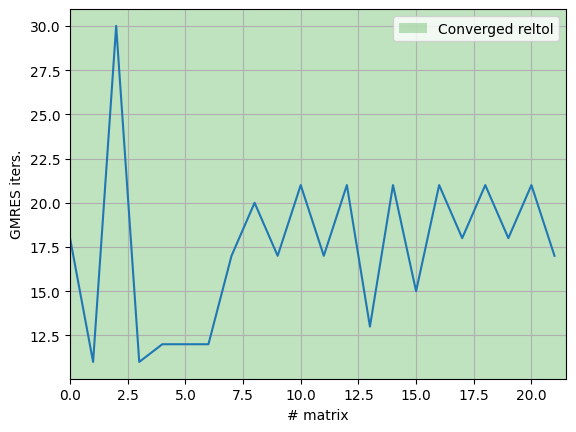

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [4]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

21

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 48
sliding = 0
open = 24
transition = 72
total = 72


In [6]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.19


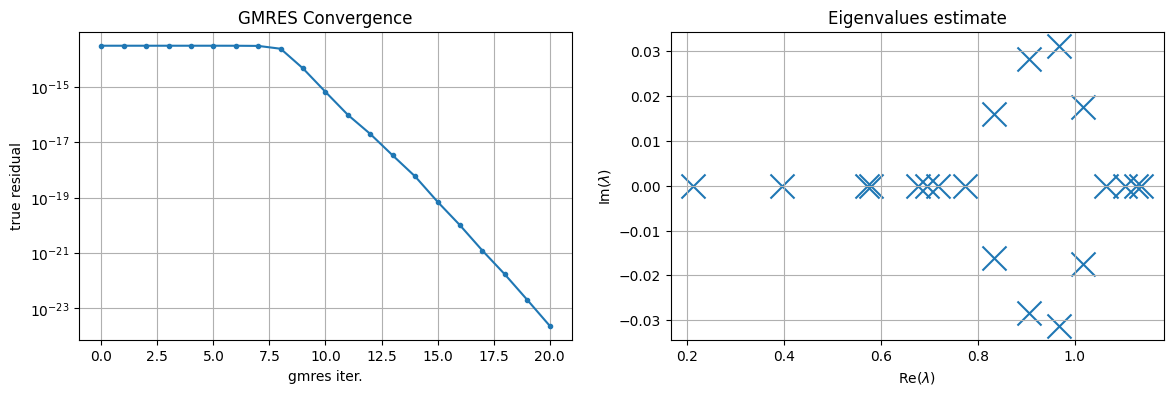

In [7]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

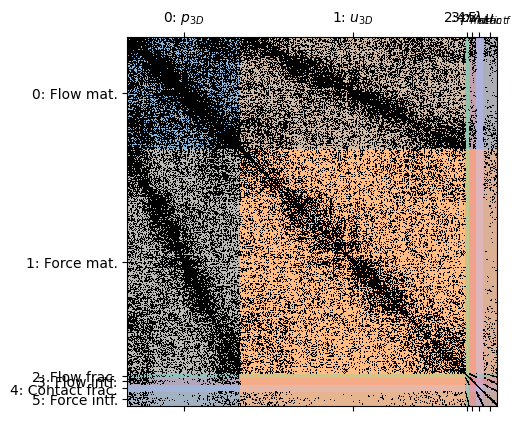

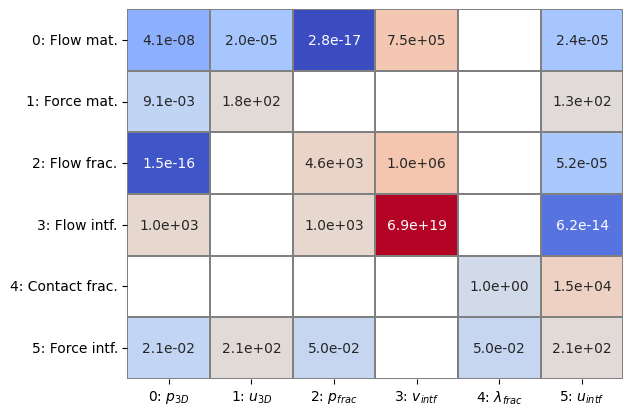

In [8]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

## Franceschini-style approach

In [9]:
def assemble_localization_matrices(bmat, keep, elim) -> list:
    # eilm: A Q1
    # keep: Q2 B


    # keep = [2]
    # elim = [1, 5]

    # keep = [5]
    # elim = [1]

    bmat = bmat[keep + elim]

    Q1 = bmat[keep, elim].mat.tocsr()
    Q2 = bmat[elim, keep].mat.tocsc()

    restrictions = []

    for frac_dof in range(Q1.shape[0]):
        restr_q1 = Q1[frac_dof, :].indices
        restr_q2 = Q2[:, frac_dof].indices
        restr = np.unique(np.concatenate([restr_q1, restr_q2]))

        col_idx = np.array(restr)
        data = np.ones_like(restr)
        row_idx = np.arange(col_idx.size)
        localization = scipy.sparse.csr_matrix(
            (data, (row_idx, col_idx)), shape=(col_idx.size, Q1.shape[1])
        )

        restrictions.append(localization)

    return restrictions
        
connectivity_list = assemble_localization_matrices(J, keep=[5], elim=[1])
connectivity_list[-1].indices

array([ 652,  653,  700,  701,  880,  881,  882,  883, 1340, 1341, 2972,
       2973, 3022, 3023, 3282, 3283], dtype=int32)

In [10]:
connectivity_list = assemble_localization_matrices(J, keep=[2], elim=[1, 5])
connectivity_list[0].indices

array([4573, 4585], dtype=int32)

Todo:

* Elim 1 -> 5 based on local indices Q1, Q2
* Elim 5 -> 2 based on local indices Q1, Q2

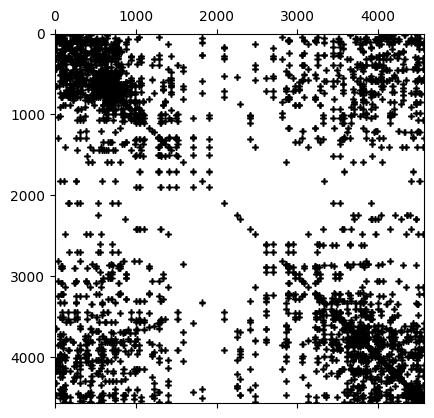

In [11]:
def make_local_prec(bmat, keep, elim):
    localization_mats = assemble_localization_matrices(bmat, keep=keep, elim=elim)


    J_keep = bmat[elim].mat
    Jkeep_inv = csr_zeros(J_keep.shape[0])

    for R in localization_mats:
        j15 = R @ J_keep @ R.T
        # j15 = R @ R.T

        j15_inv = inv(j15)
        Jkeep_inv += R.T @ j15_inv @ R

    return Jkeep_inv


J11_inv = make_local_prec(J[[1, 5]], keep=[5], elim=[1])
spy(J11_inv, marker="+")

Below gives about 35 iterations for `fpm_1_open`

In [26]:
# from block_matrix import SolveSchema, make_solver


# schema = SolveSchema(
#     groups=[1, 5],
#     solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
#     invertor=lambda bmat: make_local_prec(J, keep=[0, 2], elim=[1, 5]),
#     # invertor_type='operator',
    
#     # only_complement=True,
#     complement=SolveSchema(
#         groups=[0, 2],
#         solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
#     ),
# )
# mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
# solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-9)

In [13]:
def assemble_localization_matrices_2_15(bmat) -> list:
    # 2: A  Q1Q1Q1
    # 1: Q2 B   M1
    # 5: Q2 M2  P
    bmat = bmat[[2, 1, 5]]

    Q1 = bmat[2, [1, 5]].mat.tocsr()
    Q2 = bmat[[1, 5], 2].mat.tocsc()
    M1 = bmat[1, 5].mat.tocsc()
    M2 = bmat[5, 1].mat.tocsr()

    B_size = M1.shape[0]

    restrictions = []

    for frac_dof in range(Q1.shape[0]):
        restr_q1 = Q1[frac_dof, :].indices
        restr_q2 = Q2[:, frac_dof].indices
        restr = np.unique(np.concatenate([restr_q1, restr_q2]))

        restr_local = restr - B_size
        assert np.all(restr_local >= 0)
        restr_m1 = M1[:, restr_local].indices
        restr_m2 = M2[restr_local, :].indices

        restr_local = np.unique(np.concatenate([restr_m1, restr_m2]))
        assert len(restr_local) > 0
        assert np.all(restr_local < B_size)
        restr_total = np.concatenate([restr_local, restr])

        col_idx = np.array(restr_total)
        data = np.ones_like(restr_total)
        row_idx = np.arange(col_idx.size)
        localization = scipy.sparse.csr_matrix(
            (data, (row_idx, col_idx)), shape=(col_idx.size, Q1.shape[1])
        )

        restrictions.append(localization)

    return restrictions
        
connectivity_list = assemble_localization_matrices_2_15(J)
connectivity_list[-1].indices

array([  60,   61,  100,  101, 3508, 3509, 3668, 3669, 3718, 3719, 3750,
       3751, 3806, 3807, 3842, 3843, 3958, 3959, 3990, 3991, 4200, 4201,
       4596, 4597, 4610, 4611], dtype=int32)

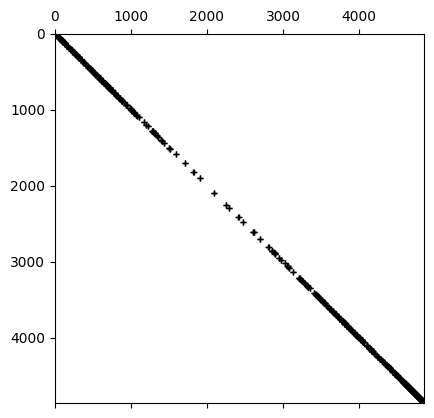

In [14]:
def make_local_prec_2_15(bmat):
    localization_mats = assemble_localization_matrices_2_15(bmat)

    J_15 = bmat[[1, 5]].mat
    J15_inv = csr_zeros(J_15.shape[0])

    for R in localization_mats:
        # j15 = R @ J_15 @ R.T
        j15 = R @ R.T

        j15_inv = inv(j15)
        J15_inv += R.T @ j15_inv @ R

    return J15_inv


J15_inv = make_local_prec_2_15(J)
spy(J15_inv, marker="+")

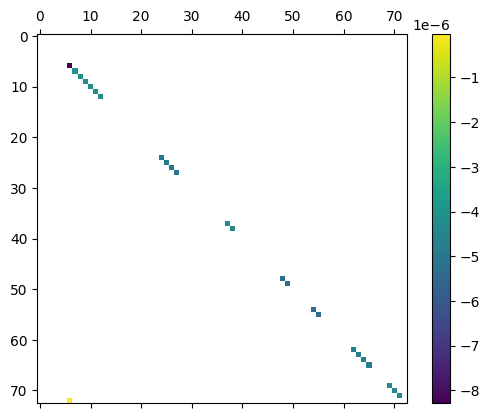

In [15]:
S22 = J[2, [1,5]].mat @ J15_inv @ J[[1, 5], 2].mat
plot_mat(S22, log=False)

Solve  took: 0.13


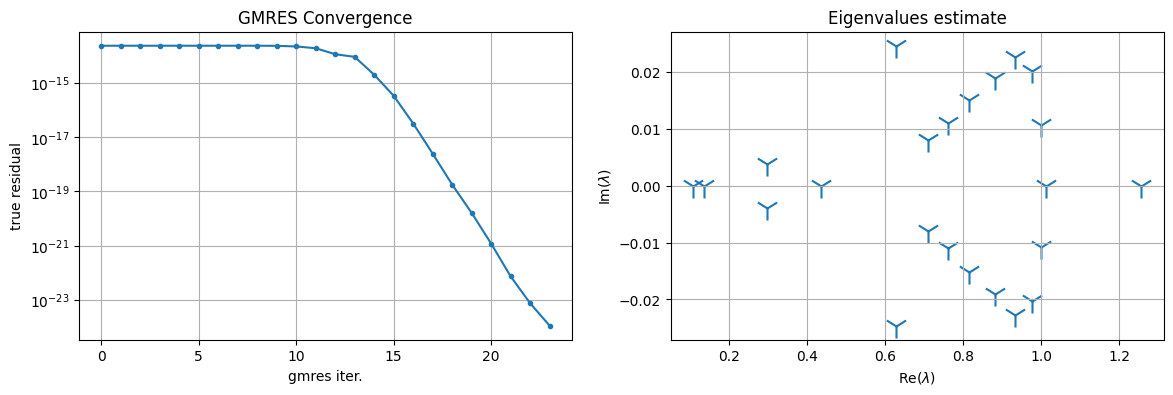

In [16]:
from block_matrix import SolveSchema, make_solver


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: make_local_prec_2_15(J),
    
    # only_complement=True,
    complement=SolveSchema(
        groups=[2],
        solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

# Flow in matrix

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


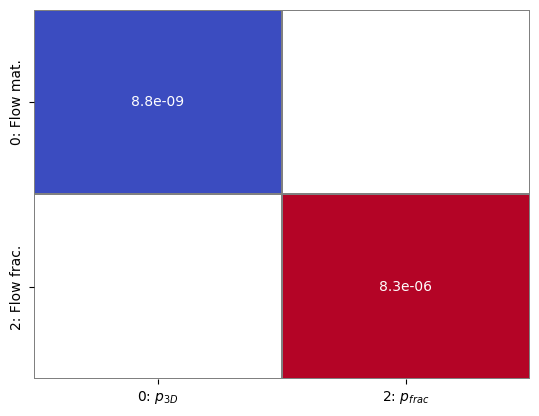

In [17]:
from pp_utils import get_fixed_stress_stabilization


def make_fs(J: BlockMatrixStorage):
    result = J.empty_container()[[0, 2]]
    result[0, 0] = get_fixed_stress_stabilization(model)
    J_15_inv = make_local_prec_2_15(J)
    result[2, 2] = - J[2, [1, 5]].mat @ J_15_inv @ J[[1, 5], 2].mat
    return result


make_fs(J).plot_max()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.16


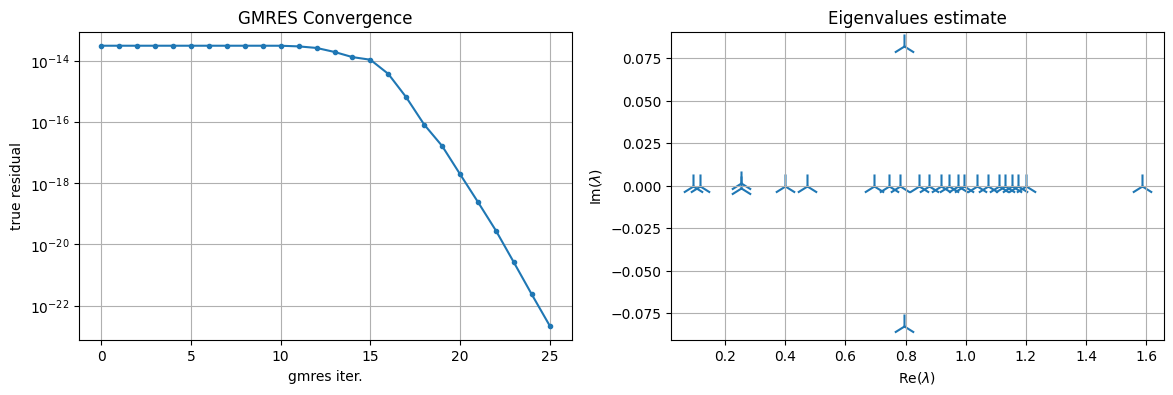

In [18]:
from block_matrix import SolveSchema, make_solver


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: make_fs(bmat).mat,
    invertor_type='physical',
    
    # only_complement=True,
    complement=SolveSchema(
        groups=[0, 2],
        solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-9)

# Import same code from source file

Solve  took: 0.16


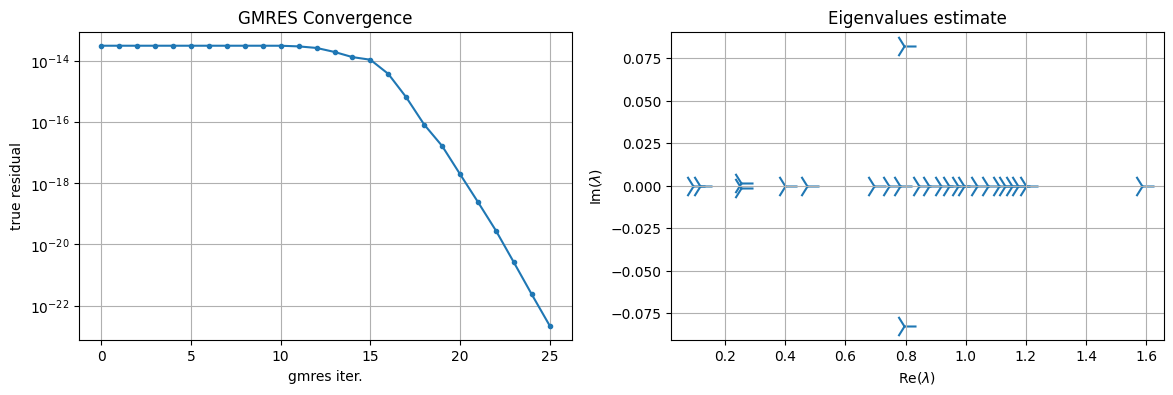

In [20]:
from fixed_stress import make_fs as make_fs_src
from block_matrix import SolveSchema, make_solver


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: make_fs_src(model, bmat).mat,
    invertor_type='physical',
    
    # only_complement=True,
    complement=SolveSchema(
        groups=[0, 2],
        solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-9)